In [1]:
import sys
import os
# setting path
sys.path.append('/work/scripts')
import pandas as pd
import seaborn as sns
import output_utils as ou
import xarray as xr
from glob import glob
import numpy as np
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt

In [2]:
cell_y_coord = 0
cell_x_coord = 1

#BONA
#cell_y_coord = 3
#cell_x_coord = 0

In [3]:
depthlist = [0.05, 0.1, 0.2, 0.3]

def get_lwclayer_tlayer(depthlist, run_dir, var):
    
    ### read the netcdf output files and compute year from the time dimension
    data = xr.open_dataset(f'{run_dir}/output/{var}_monthly_tr.nc')
    data = data.to_dataframe()
    data.reset_index(inplace=True)
    data.dtypes
    data['time'] = data['time'].astype('|S80')
    data['time'] = data['time'].astype('|datetime64[ns]')
    data['month'] = data['time'].dt.month
    data['year'] = data['time'].dt.year
    data = data.sort_values(['time','x','y','layer'])


    ### read the netcdf output files on soil structure and compute year from the time dimension
    dz = xr.open_dataset(f'{run_dir}/output/LAYERDZ_monthly_tr.nc')
    dz = dz.to_dataframe()
    dz.reset_index(inplace=True)
    dz.dtypes
    dz['time'] = dz['time'].astype('|S80')
    dz['time'] = dz['time'].astype('|datetime64[ns]')
    dz['month'] = dz['time'].dt.month
    dz['year'] = dz['time'].dt.year
    dz = dz.sort_values(['time','x','y','layer'])

    ### read the netcdf output files on soil structure and compute year from the time dimension
    lt = xr.open_dataset(f'{run_dir}/output/LAYERTYPE_monthly_tr.nc')
    lt = lt.to_dataframe()
    lt.reset_index(inplace=True)
    lt.dtypes
    lt['time'] = lt['time'].astype('|S80')
    lt['time'] = lt['time'].astype('|datetime64[ns]')
    lt['month'] = lt['time'].dt.month
    lt['year'] = lt['time'].dt.year
    lt = lt.sort_values(['time','x','y','layer'])
    dz=pd.merge(dz, lt[['LAYERTYPE', 'time', 'x', 'y', 'layer']], on=['time','x','y','layer'])


    ### compute the depth of the bottom of every layers
    dz['z'] = dz.groupby(['time','x','y'])['LAYERDZ'].cumsum(axis=0)
    
    ### loop through the list of depths of reference to compute the soil variable at that depth via linear interpolation
    stdz = []
    for i in range(len(depthlist)):
        dpth = depthlist[i]
        print("depth:", dpth,"m")
        # extract the top and bottom layers the closest to the depth of reference
        dz['diff'] = dz['z']-float(dpth)
        top = dz.loc[dz[(dz['diff'] <= 0)].groupby(['time','x','y'])['diff'].idxmax()]
        bot = dz.loc[dz[(dz['diff'] >= 0)].groupby(['time','x','y'])['diff'].idxmin()]
        # select the variable value for each of these top and bottom layers
        datatop = pd.merge(data, top[['year','month', 'x','y','layer','LAYERDZ','LAYERTYPE','z']], how="left", on=['layer','year','month', 'x','y'])
        datatop = datatop[datatop['z'].notna()]
        datatop = datatop.rename(columns={"layer": "layertop", var: var+"top", "LAYERDZ": "dztop", "z": "ztop", "LAYERTYPE": "typetop"})
        databot = pd.merge(data, bot[['year', 'month', 'x','y','layer','LAYERDZ','LAYERTYPE','z']], how="left", on=['layer','year','month' , 'x','y'])
        databot = databot[databot['z'].notna()]
        databot = databot.rename(columns={"layer": "layerbot", var: var+"bot", "LAYERDZ": "dzbot", "z": "zbot", "LAYERTYPE": "typebot"})
        # merge the data to do the linear interpolation
        datastdz = pd.merge(datatop, databot, how="outer", on=['time','year', 'month', 'x','y'])
        datastdz['a'] = (datastdz[var+"top"] - datastdz[var+"bot"]) / (datastdz['ztop'] - datastdz['zbot'])
        datastdz['b'] = datastdz[var+"top"] - (datastdz['a'] * datastdz['ztop'])
        datastdz[var] = (datastdz['a'] * float(dpth)) + datastdz['b']
        datastdz['z'] = float(dpth)
        datastdz['layer'] = i
        datastdz['type'] = datastdz['typebot']
        datastdz = datastdz[['time','x','y','layer','z','type',var]]
        stdz.append(datastdz)

    stdz = pd.concat(stdz)
    
    return stdz

In [4]:
stdz = get_lwclayer_tlayer(depthlist, '/data/workflows/US-Prr_SWC_SA/sample_000000003/', 'LWCLAYER')

depth: 0.05 m
depth: 0.1 m
depth: 0.2 m
depth: 0.3 m


In [5]:
stdz

,time,x,y,layer,z,type,LWCLAYER
0,1901-01-01,1,0,0,0.05,0.0,NaN
1,1901-02-01,1,0,0,0.05,0.0,NaN
2,1901-03-01,1,0,0,0.05,0.0,NaN
3,1901-04-01,1,0,0,0.05,0.0,NaN
4,1901-05-01,1,0,0,0.05,0.0,NaN
...,...,...,...,...,...,...,...
1447,2021-08-01,1,0,3,0.30,2.0,0.141801
1448,2021-09-01,1,0,3,0.30,2.0,0.226826
1449,2021-10-01,1,0,3,0.30,2.0,0.209473
1450,2021-11-01,1,0,3,0.30,2.0,0.062147


In [6]:
out_dir ='/data/workflows/US-Prr_SWC_SA/'

In [7]:
run_dirs = [d for d in glob(out_dir+'*/', recursive = True) if 'sample' in d]

In [8]:
run_dirs

['/data/workflows/US-Prr_SWC_SA/sample_000000015/',
 '/data/workflows/US-Prr_SWC_SA/sample_000000003/',
 '/data/workflows/US-Prr_SWC_SA/sample_000000004/',
 '/data/workflows/US-Prr_SWC_SA/sample_000000019/',
 '/data/workflows/US-Prr_SWC_SA/sample_000000011/',
 '/data/workflows/US-Prr_SWC_SA/sample_000000001/',
 '/data/workflows/US-Prr_SWC_SA/sample_000000022/',
 '/data/workflows/US-Prr_SWC_SA/sample_000000026/',
 '/data/workflows/US-Prr_SWC_SA/sample_000000021/',
 '/data/workflows/US-Prr_SWC_SA/sample_000000000/',
 '/data/workflows/US-Prr_SWC_SA/sample_000000020/',
 '/data/workflows/US-Prr_SWC_SA/sample_000000018/',
 '/data/workflows/US-Prr_SWC_SA/sample_000000002/',
 '/data/workflows/US-Prr_SWC_SA/sample_000000006/',
 '/data/workflows/US-Prr_SWC_SA/sample_000000013/',
 '/data/workflows/US-Prr_SWC_SA/sample_000000017/',
 '/data/workflows/US-Prr_SWC_SA/sample_000000009/',
 '/data/workflows/US-Prr_SWC_SA/sample_000000027/',
 '/data/workflows/US-Prr_SWC_SA/sample_000000012/',
 '/data/work

In [9]:
lwc_layers = []
t_layers = []
sample_dfs=[]
for d in run_dirs:
    if 'GPP_monthly_tr.nc' in os.listdir(os.path.join(d, 'output')):
        sample = int(d.split('/')[-2].split('_')[-1])
        
        
        TLAYER = ou.load_trsc_dataframe(var ='TLAYER', timeres='monthly', px_y=cell_y_coord, px_x=cell_x_coord, fileprefix=f'{d}output/')[0]
        LAYERDEPTH = ou.load_trsc_dataframe(var ='LAYERDEPTH', timeres='monthly', px_y=cell_y_coord, px_x=cell_x_coord, fileprefix=f'{d}output/')[0]
        LAYERDZ = ou.load_trsc_dataframe(var ='LAYERDZ', timeres='monthly', px_y=cell_y_coord, px_x=cell_x_coord, fileprefix=f'{d}output/')[0]
        GPP = ou.load_trsc_dataframe(var ='GPP', timeres='monthly', px_y=cell_y_coord, px_x=cell_x_coord, fileprefix=f'{d}output/')[0][0]
        ALD = ou.load_trsc_dataframe(var ='ALD', timeres='yearly', px_y=cell_y_coord, px_x=cell_x_coord, fileprefix=f'{d}output/')[0][0]
        RH = ou.load_trsc_dataframe(var ='RH', timeres='monthly', px_y=cell_y_coord, px_x=cell_x_coord, fileprefix=f'{d}output/')[0][0]
        ALD.columns=['ALD']
        sample_df = pd.DataFrame({'date': GPP.index, 'sample': [sample]*len(GPP), #'LWCLAYER': LWCLAYER, 'TLAYER': TLAYER, 'LAYERDEPTH': LAYERDEPTH, 'LAYERDZ': LAYERDZ,
                                  'GPP': GPP, 'RH':RH})
        sample_df = pd.merge(sample_df, ALD, how='left', left_on='date', right_index=True)
        sample_dfs.append(sample_df)
        
        LWCLAYER = get_lwclayer_tlayer(depthlist, d, 'LWCLAYER')
        LWCLAYER['sample'] = sample
        lwc_layers.append(LWCLAYER)
        
        TLAYER = get_lwclayer_tlayer(depthlist, d, 'TLAYER')
        TLAYER['sample'] = sample
        t_layers.append(TLAYER)
        
sample_dfs=pd.concat(sample_dfs)
lwc_layers=pd.concat(lwc_layers)
t_layers=pd.concat(t_layers)

Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000015/output/TLAYER_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000015/output/LAYERDEPTH_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000015/output/LAYERDZ_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000015/output/GPP_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000015/output/ALD_yearly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000015/output/RH_monthly_tr.nc
depth: 0.05 m
depth: 0.1 m
depth: 0.2 m
depth: 0.3 m
depth: 0.05 m
depth: 0.1 m
depth: 0.2 m
depth: 0.3 m
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000003/output/TLAYER_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000003/output/LAYERDEPTH_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000003/output/LAYERDZ_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000003/out

depth: 0.05 m
depth: 0.1 m
depth: 0.2 m
depth: 0.3 m
depth: 0.05 m
depth: 0.1 m
depth: 0.2 m
depth: 0.3 m
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000006/output/TLAYER_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000006/output/LAYERDEPTH_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000006/output/LAYERDZ_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000006/output/GPP_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000006/output/ALD_yearly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000006/output/RH_monthly_tr.nc
depth: 0.05 m
depth: 0.1 m
depth: 0.2 m
depth: 0.3 m
depth: 0.05 m
depth: 0.1 m
depth: 0.2 m
depth: 0.3 m
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000013/output/TLAYER_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000013/output/LAYERDEPTH_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_

depth: 0.05 m
depth: 0.1 m
depth: 0.2 m
depth: 0.3 m
depth: 0.05 m
depth: 0.1 m
depth: 0.2 m
depth: 0.3 m
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000014/output/TLAYER_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000014/output/LAYERDEPTH_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000014/output/LAYERDZ_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000014/output/GPP_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000014/output/ALD_yearly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000014/output/RH_monthly_tr.nc
depth: 0.05 m
depth: 0.1 m
depth: 0.2 m
depth: 0.3 m
depth: 0.05 m
depth: 0.1 m
depth: 0.2 m
depth: 0.3 m
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000023/output/TLAYER_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000023/output/LAYERDEPTH_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_

In [10]:
path_to_met_data = '/data/comparison_data/US-Prr-monthly.csv'

In [11]:
met_data = pd.read_csv(path_to_met_data)
met_data['m_y'] = pd.to_datetime(met_data['m_y'])
met_data['year'] = met_data['m_y'].dt.year
met_data = met_data.replace(-9999.0, np.nan)
met_data['SWC_1_1_1'] = met_data['SWC_1_1_1']/100
met_data['SWC_1_2_1'] = met_data['SWC_1_2_1']/100
met_data['SWC_1_3_1'] = met_data['SWC_1_3_1']/100
met_data['SWC_1_4_1'] = met_data['SWC_1_4_1']/100
met_data.head()


,Unnamed: 0,Year_x,Month_x,GPP1 (gC/m2/d),RECO1 (gC/m2/d),NEE1 (gC/m2/d),GPP2 (gC/m2/d),RECO2 (gC/m2/d),NEE2 (gC/m2/d),Precip (mm),...,SWC_1_5_1,TS_1_1_1,TS_1_2_1,TS_1_3_1,TS_1_4_1,TS_1_5_1,TS_1_6_1,CO2,SW_IN,year
0,0,2010,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010
1,1,2010,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010
2,2,2010,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010
3,3,2010,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010
4,4,2010,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010


In [12]:
sample_dfs = sample_dfs.reset_index(drop=True)

In [13]:
sample_dfs

,date,sample,GPP,RH,0
0,1901-01-01,15,0.000000,0.496082,5.728211
1,1901-02-01,15,0.000000,0.716624,NaN
2,1901-03-01,15,0.000000,0.110508,NaN
3,1901-04-01,15,0.000000,0.988432,NaN
4,1901-05-01,15,45.689560,6.829089,NaN
...,...,...,...,...,...
40651,2021-08-01,23,66.296940,0.000000,NaN
40652,2021-09-01,23,56.296400,0.000000,NaN
40653,2021-10-01,23,1.347227,0.000000,NaN
40654,2021-11-01,23,0.000000,0.000000,NaN


In [14]:
sample_dfs[sample_dfs['date'].dt.year>2010]

,date,sample,GPP,RH,0
1320,2011-01-01,15,0.000000,7.264014,5.738819
1321,2011-02-01,15,0.000000,7.282188,NaN
1322,2011-03-01,15,0.000000,7.007988,NaN
1323,2011-04-01,15,17.302045,7.204501,NaN
1324,2011-05-01,15,49.252624,20.777007,NaN
...,...,...,...,...,...
40651,2021-08-01,23,66.296940,0.000000,NaN
40652,2021-09-01,23,56.296400,0.000000,NaN
40653,2021-10-01,23,1.347227,0.000000,NaN
40654,2021-11-01,23,0.000000,0.000000,NaN


<AxesSubplot:xlabel='date', ylabel='GPP'>

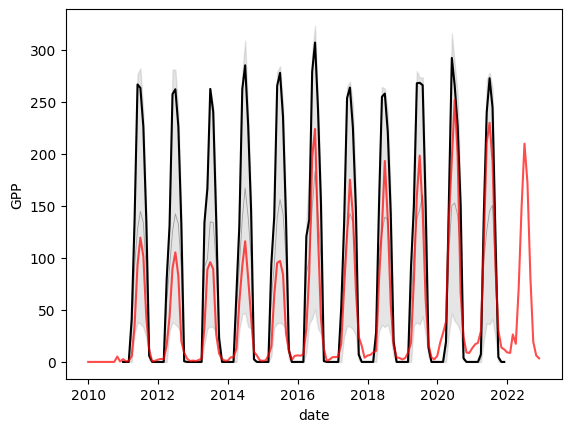

In [54]:
#9, 17, 18, 19, 23, 24, 37, 42
sns.lineplot(data=sample_dfs[sample_dfs['date'].dt.year>2010], x='date', y='GPP', color='grey', legend=False, alpha=0.7, errorbar = 'pi', linewidth=0.6)
sns.lineplot(data=sample_dfs[(sample_dfs['date'].dt.year>2010) & (sample_dfs['sample']==22)], x='date', y='GPP', color='black', legend=False)
sns.lineplot(data=met_data, x='m_y', y='GPP1 (gC/m2/d)', color='red', alpha=0.7)#
#sns.scatterplot(data=met_data, x='m_y', y='GPP2 (gC/m2/d)', color='blue', alpha=0.7, s=10)

In [16]:
met_data

,Unnamed: 0,Year_x,Month_x,GPP1 (gC/m2/d),RECO1 (gC/m2/d),NEE1 (gC/m2/d),GPP2 (gC/m2/d),RECO2 (gC/m2/d),NEE2 (gC/m2/d),Precip (mm),...,SWC_1_5_1,TS_1_1_1,TS_1_2_1,TS_1_3_1,TS_1_4_1,TS_1_5_1,TS_1_6_1,CO2,SW_IN,year
0,0,2010,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010
1,1,2010,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010
2,2,2010,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010
3,3,2010,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010
4,4,2010,5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,151,2022,8,172.143095,175.243983,3.100888,347.097889,409.740752,62.642863,63.5,...,76.097014,4.043485,3.492134,3.395774,3.600310,2.758546,0.238595,432.237636,165.769305,2022
152,152,2022,9,81.015993,108.353769,27.337777,169.675557,264.044531,94.368974,39.0,...,76.405067,1.299983,1.528081,2.148819,2.756389,2.138210,0.151891,441.144164,86.208527,2022
153,153,2022,10,19.200998,40.810212,21.609214,37.596832,105.285708,67.688876,28.0,...,76.425855,0.193642,0.790048,1.795578,2.340833,1.778759,0.066593,441.635431,37.825830,2022
154,154,2022,11,6.136981,12.626030,6.489049,6.889540,29.696461,22.806921,14.0,...,75.965979,-0.046560,1.490735,2.519482,2.571293,1.892466,0.066099,437.010359,7.629517,2022


<AxesSubplot:xlabel='date', ylabel='RH'>

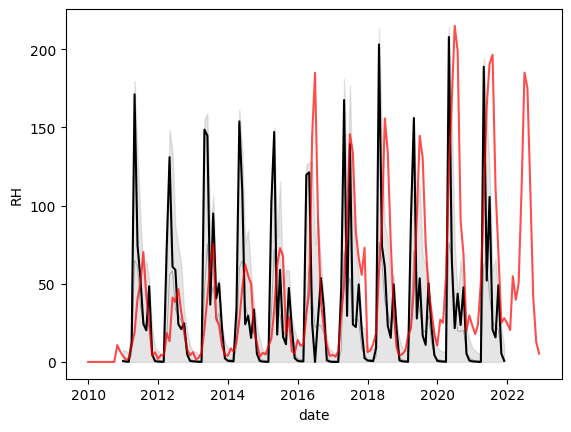

In [17]:
#9, 17, 18, 19, 23, 24, 37, 42
sns.lineplot(data=sample_dfs[sample_dfs['date'].dt.year>2010], x='date', y='RH', color='grey', legend=False, alpha=0.7, errorbar = 'pi', linewidth=0.6)
sns.lineplot(data=sample_dfs[(sample_dfs['date'].dt.year>2010) & (sample_dfs['sample']==13)], x='date', y='RH', color='black', legend=False)
sns.lineplot(data=met_data, x='m_y', y='RECO1 (gC/m2/d)', color='red', alpha=0.7)#
#sns.scatterplot(data=met_data, x='m_y', y='GPP2 (gC/m2/d)', color='blue', alpha=0.7, s=10)

In [18]:
t_layers=t_layers.reset_index(drop=True)
lwc_layers=lwc_layers.reset_index(drop=True)

In [19]:
tlayer_merged = t_layers[['time', 'z', 'TLAYER', 'sample']].merge(met_data[['m_y', 'TS_1_2_1', 'TS_1_3_1', 'TS_1_4_1']], left_on = ['time'], right_on=['m_y'], how='left')
tlayer_merged= tlayer_merged.loc[~tlayer_merged['TS_1_2_1'].isna() & ~tlayer_merged['TS_1_3_1'].isna() & ~tlayer_merged['TS_1_4_1'].isna() & ~tlayer_merged['TLAYER'].isna()]

In [20]:
lwclayer_merged = lwc_layers[['time', 'z', 'LWCLAYER', 'sample']].merge(met_data[['m_y', 'SWC_1_2_1', 'SWC_1_3_1']], left_on = ['time'], right_on=['m_y'], how='left')
lwclayer_merged= lwclayer_merged.loc[~lwclayer_merged['SWC_1_2_1'].isna() & ~lwclayer_merged['SWC_1_3_1'].isna() & ~lwclayer_merged['LWCLAYER'].isna()]

In [21]:
r2s_10cm = []
r2s_20cm = []
r2s_30cm = []
samples = []
for sample in tlayer_merged['sample'].unique():
    tlayer_sample = tlayer_merged.loc[tlayer_merged['sample']==sample]
    if len(tlayer_sample.loc[tlayer_sample['z']==0.1])>0:
        r2_10cm = r2_score(tlayer_sample.loc[tlayer_sample['z']==0.1, 'TS_1_2_1'], tlayer_sample.loc[tlayer_sample['z']==0.1, 'TLAYER'])
        r2_20cm = r2_score(tlayer_sample.loc[tlayer_sample['z']==0.2, 'TS_1_3_1'], tlayer_sample.loc[tlayer_sample['z']==0.2, 'TLAYER'])
        r2_30cm = r2_score(tlayer_sample.loc[tlayer_sample['z']==0.3, 'TS_1_4_1'], tlayer_sample.loc[tlayer_sample['z']==0.3, 'TLAYER'])

        samples.append(sample)
        r2s_10cm.append(r2_10cm)
        r2s_20cm.append(r2_20cm)
        r2s_30cm.append(r2_30cm)
    
df_tlayer = pd.DataFrame({'sample': samples, 'r2_10cm': r2s_10cm, 'r2_20cm': r2s_20cm, 'r2_30cm': r2s_30cm})

In [22]:
df_tlayer.sort_values(by='r2_20cm')

,sample,r2_10cm,r2_20cm,r2_30cm
19,5,-32.561549,-39.711435,-35.343000
7,21,-25.779717,-24.431989,-13.887948
13,13,-21.167794,-23.601294,-19.822455
6,26,-19.041917,-18.965704,-11.813057
9,20,-21.589520,-17.745416,-10.508870
1,3,-13.295220,-14.606984,-10.729746
24,7,-12.196035,-14.556635,-13.038411
8,0,-14.499514,-14.259462,-6.739487
12,6,-12.565340,-13.736978,-9.958561
17,12,-11.535592,-11.892441,-4.600741


<AxesSubplot:xlabel='time', ylabel='TLAYER'>

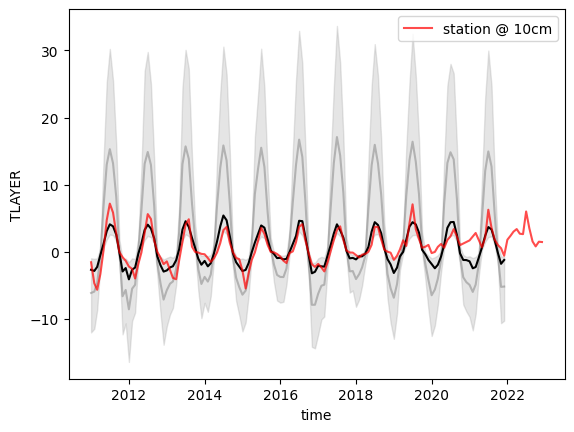

In [23]:
sns.lineplot(data=t_layers.loc[(t_layers['z']==0.1) & (t_layers['time'].dt.year>2010)], x='time', y='TLAYER', color = 'grey', alpha=0.5, errorbar = 'pi')
sns.lineplot(data=t_layers.loc[(t_layers['z']==0.1) & (t_layers['time'].dt.year>2010) & (t_layers['sample']==16)], x='time', y='TLAYER', color = 'black')
sns.lineplot(data = met_data.loc[met_data['year']>2010], x='m_y', y='TS_1_2_1', color='red', alpha = 0.7, label='station @ 10cm') #-0.1 m

<AxesSubplot:xlabel='time', ylabel='TLAYER'>

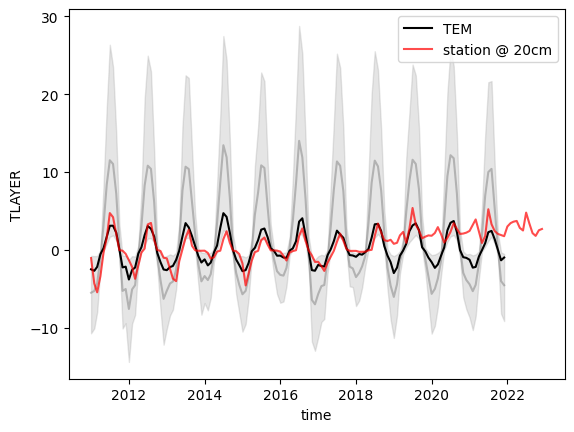

In [24]:
sns.lineplot(data=t_layers.loc[(t_layers['z']==0.2) & (t_layers['time'].dt.year>2010)], x='time', y='TLAYER', color = 'grey', alpha=0.5, errorbar = 'pi')
sns.lineplot(data=t_layers.loc[(t_layers['z']==0.2) & (t_layers['time'].dt.year>2010) & (t_layers['sample']==16)], x='time', y='TLAYER', color = 'black', label = 'TEM')
sns.lineplot(data = met_data.loc[met_data['year']>2010], x='m_y', y='TS_1_3_1', color='red', alpha = 0.7, label='station @ 20cm') #-0.1 m

<AxesSubplot:xlabel='time', ylabel='TLAYER'>

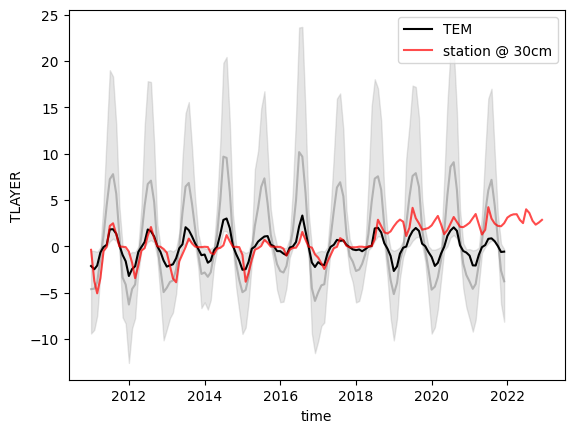

In [25]:
sns.lineplot(data=t_layers.loc[(t_layers['z']==0.3) & (t_layers['time'].dt.year>2010)], x='time', y='TLAYER', color = 'grey', alpha=0.5, errorbar = 'pi')
sns.lineplot(data=t_layers.loc[(t_layers['z']==0.3) & (t_layers['time'].dt.year>2010) & (t_layers['sample']==16)], x='time', y='TLAYER', color = 'black', label = 'TEM')
sns.lineplot(data = met_data.loc[met_data['year']>2010], x='m_y', y='TS_1_4_1', color='red', alpha = 0.7, label='station @ 30cm') #-0.1 m

In [26]:
lwclayer_merged

,time,z,LWCLAYER,sample,m_y,SWC_1_2_1,SWC_1_3_1
2776,2011-05-01,0.1,0.249992,15,2011-05-01,0.390908,0.186683
2777,2011-06-01,0.1,0.215729,15,2011-06-01,0.814515,0.708910
2778,2011-07-01,0.1,0.330542,15,2011-07-01,0.809233,0.836910
2779,2011-08-01,0.1,0.500997,15,2011-08-01,0.831707,0.836910
2780,2011-09-01,0.1,0.464195,15,2011-09-01,0.836910,0.836910
...,...,...,...,...,...,...,...
162618,2021-07-01,0.3,0.363233,23,2021-07-01,0.655261,0.755904
162619,2021-08-01,0.3,0.397231,23,2021-08-01,0.751810,0.835364
162620,2021-09-01,0.3,0.405660,23,2021-09-01,0.839350,0.838763
162622,2021-11-01,0.3,0.025167,23,2021-11-01,0.561844,0.715605


In [27]:
lwclayer_r2s_10cm = []
lwclayer_r2s_20cm = []
samples = []
for sample in tlayer_merged['sample'].unique():
    lwclayer_sample = lwclayer_merged.loc[lwc_layers['sample']==sample]
    if len(lwclayer_sample.loc[lwclayer_sample['z']==0.1])>0:
        r2_10cm = r2_score(lwclayer_sample.loc[lwclayer_sample['z']==0.1, 'SWC_1_2_1'], lwclayer_sample.loc[lwclayer_sample['z']==0.1, 'LWCLAYER'])
        r2_20cm = r2_score(lwclayer_sample.loc[lwclayer_sample['z']==0.2, 'SWC_1_3_1'], lwclayer_sample.loc[lwclayer_sample['z']==0.2, 'LWCLAYER'])

        samples.append(sample)
        lwclayer_r2s_10cm.append(r2_10cm)
        lwclayer_r2s_20cm.append(r2_20cm)
    
df_lwclayer = pd.DataFrame({'sample': samples, 'r2_10cm': lwclayer_r2s_10cm, 'r2_20cm': lwclayer_r2s_20cm})

In [28]:
df_lwclayer.sort_values(by='r2_20cm')

,sample,r2_10cm,r2_20cm
10,20,-1.105667,-2.307185
1,3,-1.314145,-2.218509
5,1,-1.054181,-1.953282
7,26,-1.271444,-1.888788
26,14,-1.199922,-1.868083
22,25,-1.181529,-1.833195
19,24,-1.261737,-1.804964
4,11,-0.977798,-1.800456
21,8,-0.840816,-1.745419
18,12,-1.190586,-1.736157


<AxesSubplot:xlabel='time', ylabel='LWCLAYER'>

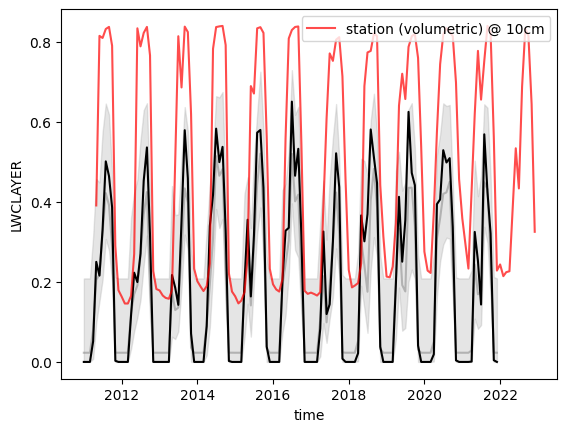

In [47]:
sns.lineplot(data=lwc_layers.loc[(lwc_layers['z']==0.1) & (lwc_layers['time'].dt.year>2010)], x='time', y='LWCLAYER', color = 'grey', alpha = 0.5, errorbar = 'pi')
sns.lineplot(data=lwc_layers.loc[(lwc_layers['z']==0.1) & (lwc_layers['time'].dt.year>2010) & (lwc_layers['sample']==15)], x='time', y='LWCLAYER', color = 'black')
sns.lineplot(data = met_data.loc[met_data['year']>2010], x='m_y', y='SWC_1_2_1', color = 'red', alpha = 0.7, label='station (volumetric) @ 10cm') #-0.1 m


<AxesSubplot:xlabel='time', ylabel='LWCLAYER'>

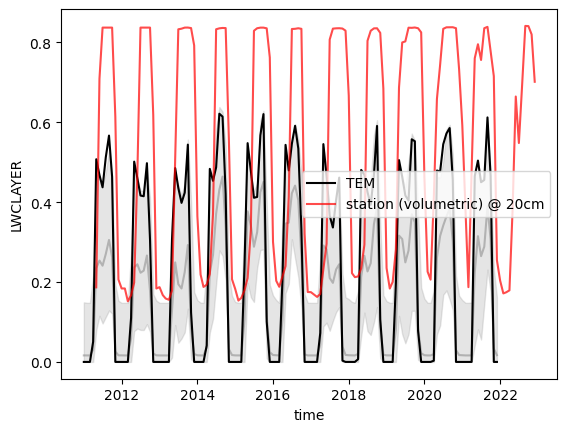

In [53]:
sns.lineplot(data=lwc_layers.loc[(lwc_layers['z']==0.2) & (lwc_layers['time'].dt.year>2010)], x='time', y='LWCLAYER', color = 'grey', alpha = 0.5, errorbar = 'pi')
sns.lineplot(data=lwc_layers.loc[(lwc_layers['z']==0.2) & (lwc_layers['time'].dt.year>2010) & (lwc_layers['sample']==22)], x='time', y='LWCLAYER', color = 'black', label='TEM')
sns.lineplot(data = met_data.loc[met_data['year']>2010], x='m_y', y='SWC_1_3_1', color = 'red', alpha = 0.7, label='station (volumetric) @ 20cm') #-0.1 m


<AxesSubplot:xlabel='time', ylabel='LWCLAYER'>

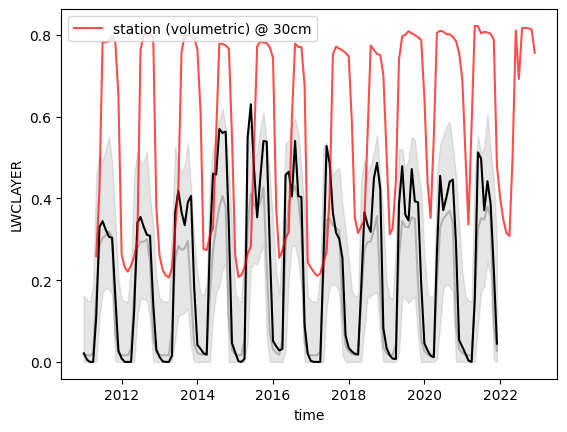

In [49]:
sns.lineplot(data=lwc_layers.loc[(lwc_layers['z']==0.3) & (lwc_layers['time'].dt.year>2010)], x='time', y='LWCLAYER', color = 'grey', alpha = 0.5, errorbar = 'pi')
sns.lineplot(data=lwc_layers.loc[(lwc_layers['z']==0.3) & (lwc_layers['time'].dt.year>2010) & (lwc_layers['sample']==15)], x='time', y='LWCLAYER', color = 'black')
sns.lineplot(data = met_data.loc[met_data['year']>2010], x='m_y', y='SWC_1_4_1', color = 'red', alpha = 0.7, label='station (volumetric) @ 30cm') #-0.1 m

In [50]:
sample_matrix=pd.read_csv('/data/workflows/US-Prr_SWC_SA/sample_matrix.csv')

In [33]:
sample_matrix

,hksat(m),hksat(f),hksat(h),tcsolid(m),tcsolid(f),tcsolid(h),porosity(m),porosity(f),porosity(h),nfactor(s),nfactor(w),rhq10
0,0.002917,0.003200,0.000111,0.191482,0.028281,0.028095,0.838713,0.825985,0.760112,1.828567,0.118526,2.375928
1,0.002137,0.000288,0.000336,0.189761,0.007345,0.256294,0.894792,0.808737,0.761185,0.520836,0.362930,1.893089
2,0.001336,0.003486,0.000102,0.007610,0.179169,1.736341,0.921132,0.805116,0.706505,2.382437,0.969069,2.246718
3,0.000618,0.002736,0.000513,0.048732,0.065430,0.222447,0.835158,0.827280,0.725878,1.723801,0.380540,2.016054
4,0.001384,0.000126,0.000421,0.006518,0.035271,0.362934,0.919685,0.827656,0.708849,0.650761,0.140705,1.860264
5,0.001334,0.000073,0.000130,0.062810,0.324847,0.492637,0.851139,0.824066,0.707455,2.469840,0.795020,1.758973
6,0.000721,0.000083,0.000313,0.038197,0.008344,0.162223,0.883770,0.803476,0.786310,1.633586,0.397808,1.650847
7,0.001230,0.000058,0.000316,0.298111,0.048330,0.359870,0.847939,0.821397,0.776079,1.490938,0.793870,1.995036
8,0.001144,0.000081,0.000053,0.025165,0.005268,0.294889,0.877153,0.815257,0.790757,0.773372,0.469345,2.204441
9,0.001785,0.001043,0.000475,0.008572,0.043280,1.268662,0.925011,0.826144,0.780367,0.629111,0.903303,2.031474


In [34]:
#9, 22, 4,23 

In [35]:
sample_matrix.iloc[[9,22,4,23]].min()

hksat(m)       0.001384
hksat(f)       0.000116
hksat(h)       0.000137
tcsolid(m)     0.006518
tcsolid(f)     0.005288
tcsolid(h)     0.362934
porosity(m)    0.886337
porosity(f)    0.802819
porosity(h)    0.708849
nfactor(s)     0.282667
nfactor(w)     0.140705
rhq10          1.860264
dtype: float64

In [36]:
sample_matrix.iloc[[9,22,4,23]].max()

hksat(m)       0.003470
hksat(f)       0.001043
hksat(h)       0.000475
tcsolid(m)     0.028023
tcsolid(f)     0.435239
tcsolid(h)     1.876945
porosity(m)    0.951404
porosity(f)    0.827656
porosity(h)    0.786707
nfactor(s)     2.300453
nfactor(w)     0.903303
rhq10          2.034116
dtype: float64

In [37]:
sample_dfs['month'] = sample_dfs['date'].dt.month
t_layers['month'] = t_layers['time'].dt.month
lwc_layers['month'] = lwc_layers['time'].dt.month

In [38]:
sample_summary_s = sample_dfs.loc[(sample_dfs['month']>=6) & (sample_dfs['month']<10), ['sample', 'GPP', 'RH']].groupby(by='sample').mean()
t_layers_summary_s = t_layers.loc[(t_layers['month']>=6) & (t_layers['month']<10), ['sample', 'z', 'type', 'TLAYER']].groupby(by=['sample', 'z']).mean().reset_index()
lwc_layers_summary_s = lwc_layers.loc[(lwc_layers['month']>=6) & (lwc_layers['month']<10), ['sample', 'z', 'type', 'LWCLAYER']].groupby(by=['sample', 'z']).mean().reset_index()

In [39]:
sample_summary_w = sample_dfs.loc[(sample_dfs['month']<6) | (sample_dfs['month']>=10), ['sample', 'GPP', 'RH']].groupby(by='sample').mean()
t_layers_summary_w = t_layers.loc[(t_layers['month']<6) | (t_layers['month']>=10), ['sample', 'z', 'type', 'TLAYER']].groupby(by=['sample', 'z']).mean().reset_index()
lwc_layers_summary_w = lwc_layers.loc[(lwc_layers['month']<6) | (lwc_layers['month']>=10), ['sample', 'z', 'type', 'LWCLAYER']].groupby(by=['sample', 'z']).mean().reset_index()

In [40]:
sample_summary_s = sample_summary_s.merge(sample_matrix, left_index=True, right_index=True)
sample_summary_s = sample_summary_s.merge(t_layers_summary_s, left_index=True, right_on='sample', how='right')
sample_summary_s = sample_summary_s.merge(lwc_layers_summary_s, on=['sample', 'z'])

sample_summary_w = sample_summary_w.merge(sample_matrix, left_index=True, right_index=True)
sample_summary_w = sample_summary_w.merge(t_layers_summary_w, left_index=True, right_on='sample', how='right')
sample_summary_w = sample_summary_w.merge(lwc_layers_summary_w, on=['sample', 'z'])

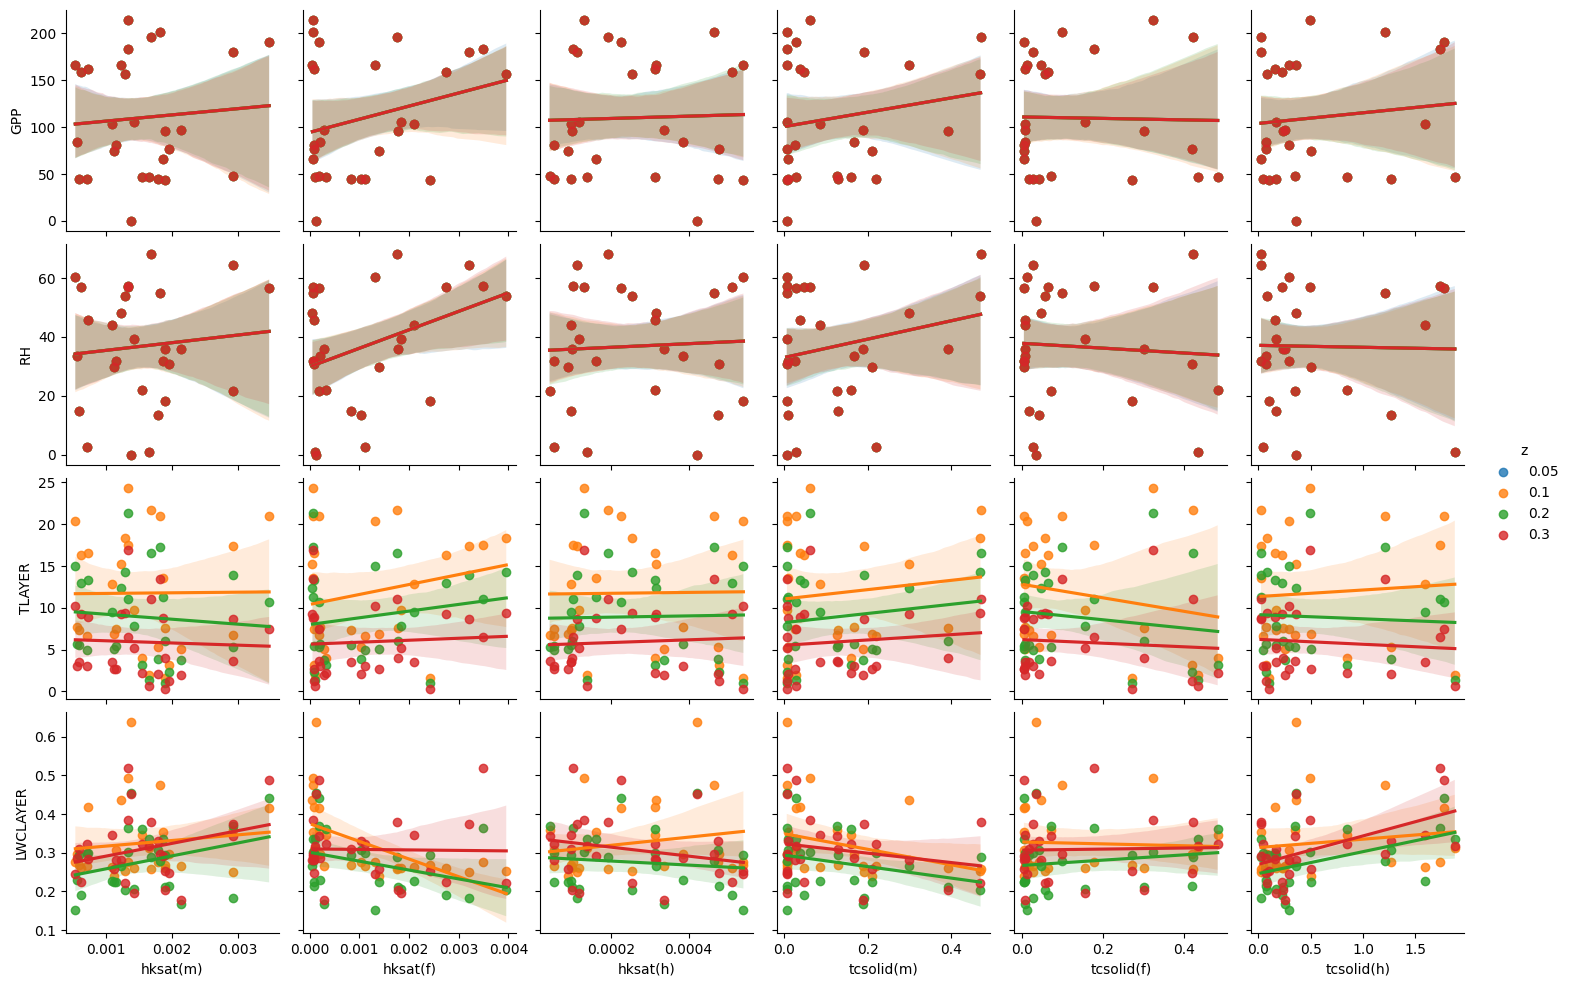

In [41]:
sns.pairplot(data=sample_summary_s, x_vars=['hksat(m)','hksat(f)','hksat(h)',
          'tcsolid(m)', 'tcsolid(f)', 'tcsolid(h)'], y_vars= ['GPP', 'RH', 'TLAYER', 'LWCLAYER'], hue='z', kind='reg')

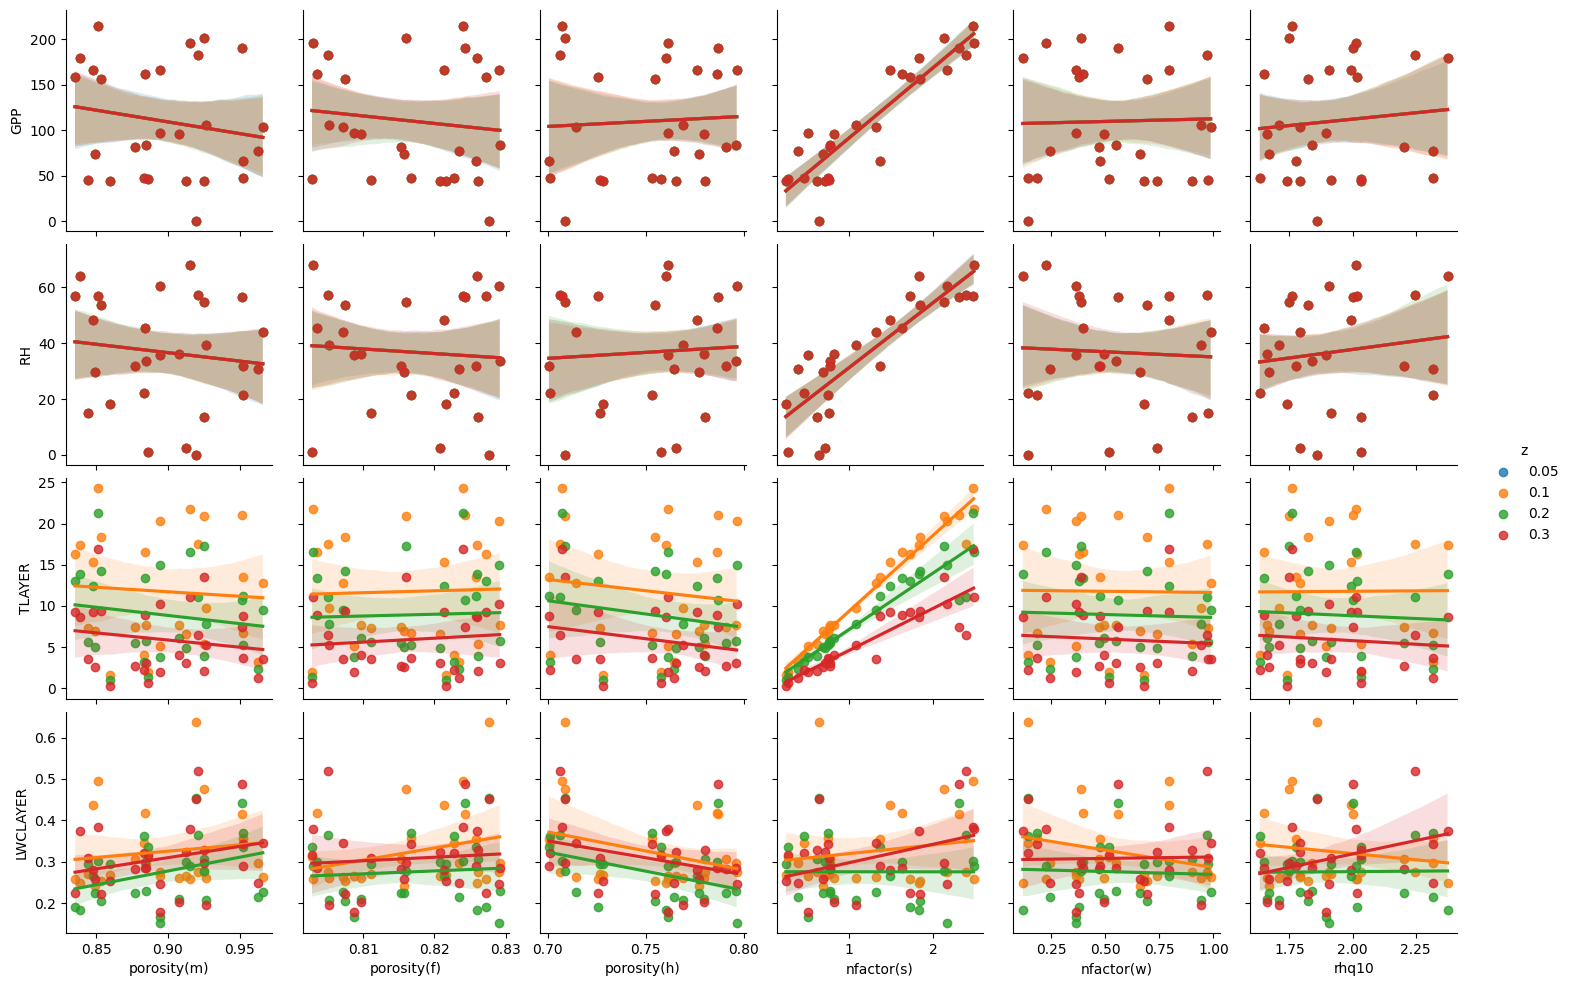

In [42]:
sns.pairplot(data=sample_summary_s, x_vars=['porosity(m)', 'porosity(f)', 'porosity(h)', 'nfactor(s)', 'nfactor(w)', 'rhq10'], 
             y_vars= ['GPP', 'RH', 'TLAYER', 'LWCLAYER'], hue='z', kind='reg')

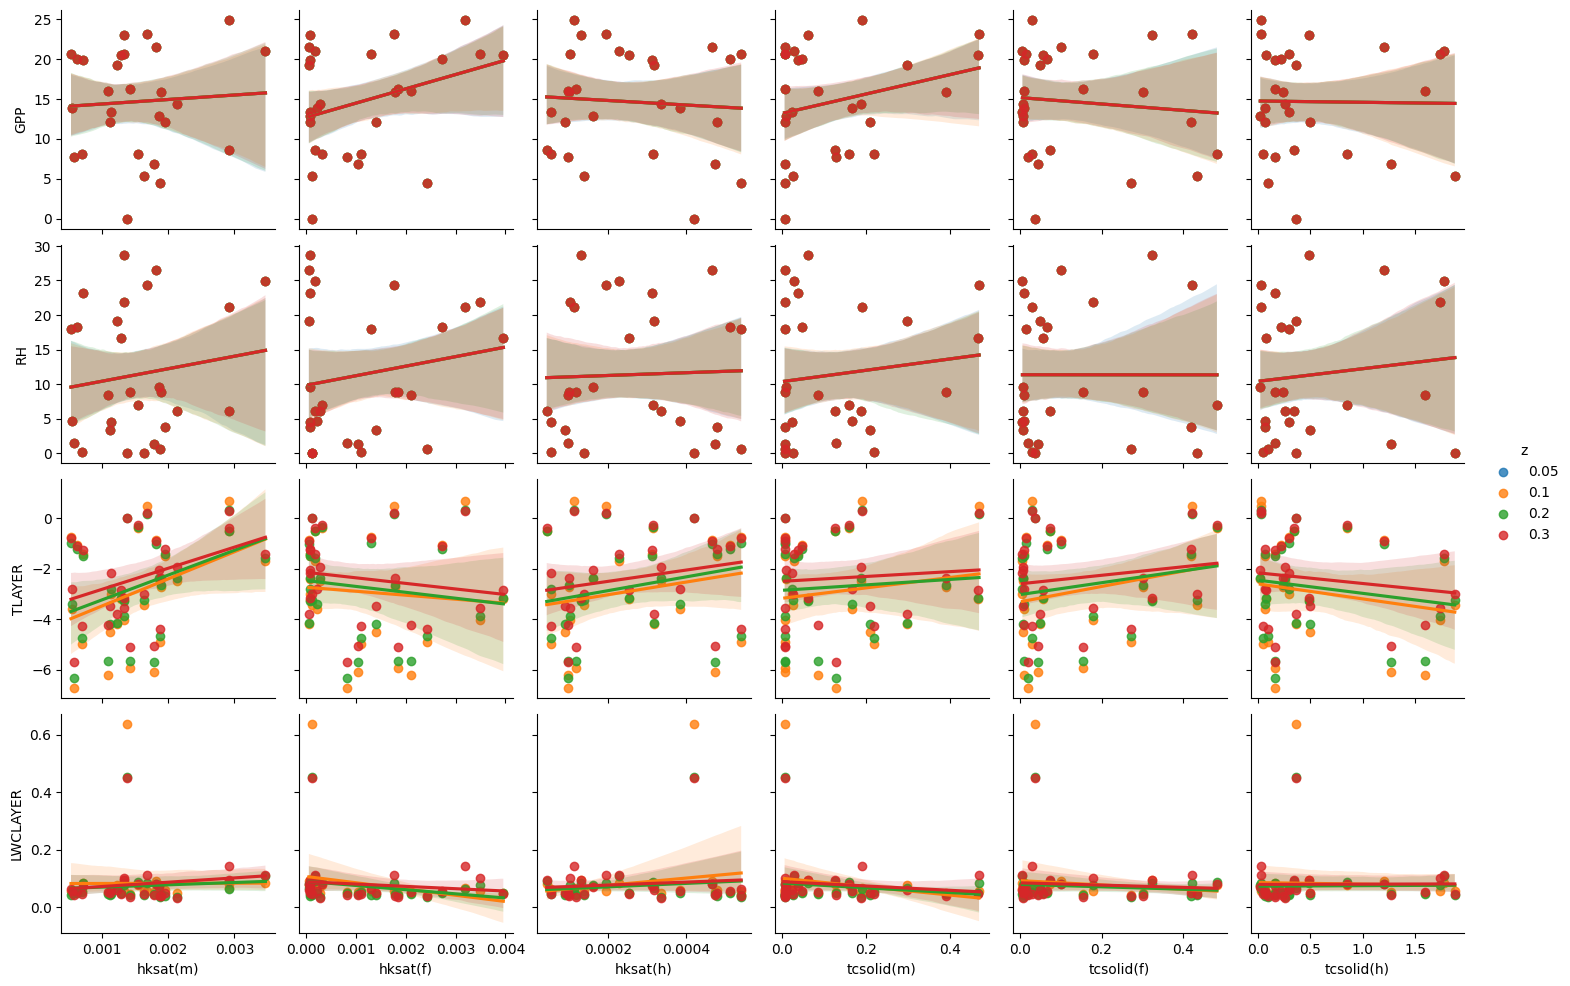

In [43]:
sns.pairplot(data=sample_summary_w, x_vars=['hksat(m)','hksat(f)','hksat(h)',
          'tcsolid(m)', 'tcsolid(f)', 'tcsolid(h)'], y_vars= ['GPP', 'RH', 'TLAYER', 'LWCLAYER'], hue='z', kind='reg')

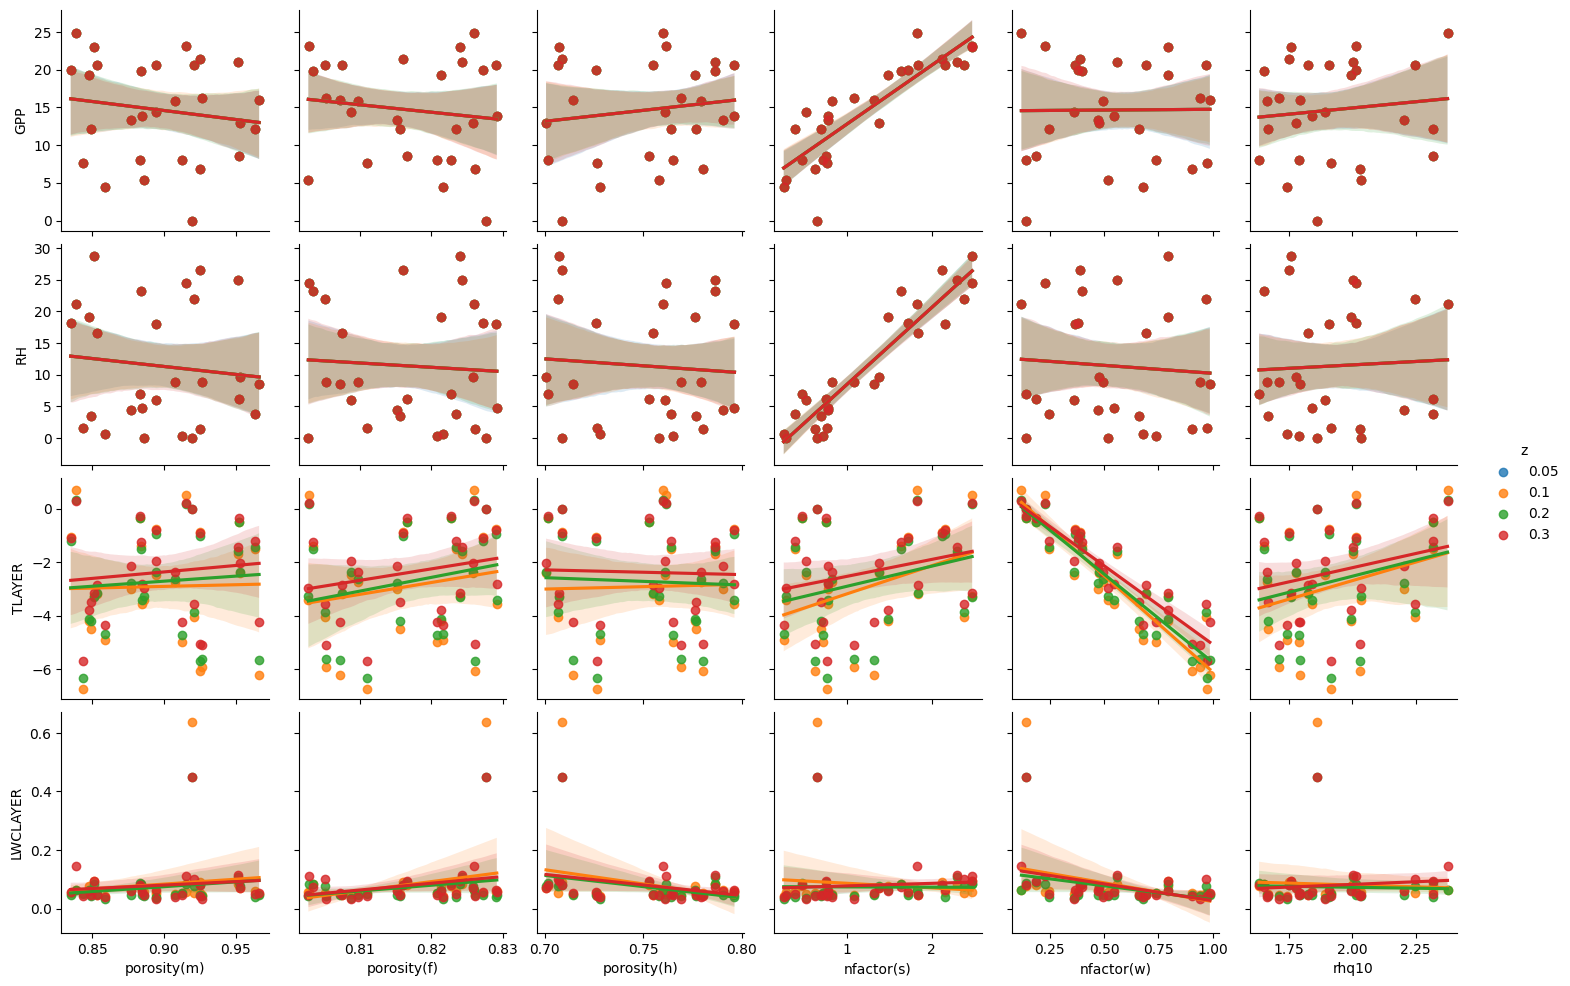

In [44]:
sns.pairplot(data=sample_summary_w, x_vars=['porosity(m)', 'porosity(f)', 'porosity(h)', 'nfactor(s)', 'nfactor(w)', 'rhq10'], 
             y_vars= ['GPP', 'RH', 'TLAYER', 'LWCLAYER'], hue='z', kind='reg')